In [1]:
#! pip install causalml

In [2]:
# https://chatgpt.com/share/67bbde9c-5d40-8000-9325-0e1fa5373885


import pandas as pd

# Hillstromデータの読み込み（事前にCSVをダウンロードしてパスを指定）
df = pd.read_csv("hillstrom.csv")
print("データ件数:", len(df))
df.head()


データ件数: 64000


,recency,history_segment,history,mens,womens,zip_code,newbie,channel,segment,visit,conversion,spend
0,10,2) $100 - $200,142.44,1,0,Surburban,0,Phone,Womens E-Mail,0,0,0.0
1,6,3) $200 - $350,329.08,1,1,Rural,1,Web,No E-Mail,0,0,0.0
2,7,2) $100 - $200,180.65,0,1,Surburban,1,Web,Womens E-Mail,0,0,0.0
3,9,5) $500 - $750,675.83,1,0,Rural,1,Web,Mens E-Mail,0,0,0.0
4,2,1) $0 - $100,45.34,1,0,Urban,0,Web,Womens E-Mail,0,0,0.0


In [3]:
# 改良版
# https://chatgpt.com/share/67bf207f-3fd4-8000-aa54-e2c57cd13e86

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from causalml.inference.meta import BaseSRegressor, BaseTRegressor, BaseXRegressor, BaseRRegressor
from causalml.inference.tree import UpliftTreeClassifier, UpliftRandomForestClassifier
from causalml.metrics import qini_score, plot_qini
import matplotlib.pyplot as plt

# ==========
# 1. データ読み込み
# ==========
df = pd.read_csv("hillstrom.csv")  # CSVパスは適宜修正
print("データ件数:", len(df))
df.head()

# ==========
# 2. 前処理
# ==========
# 大文字始まりにそろえる (例: 'recency' -> 'Recency')
df.columns = [col.capitalize() for col in df.columns]

# 処置フラグ(1/0) とグループラベル(control/treatment)を作成
df['treatment'] = (df['Segment'] != 'No E-Mail').astype(int)
df['group'] = df['Segment'].apply(lambda x: 'control' if x == 'No E-Mail' else 'treatment')

# 分析で使う特徴量例
features = ['Recency', 'History', 'Mens', 'Womens', 'Newbie']
X = df[features]
y = df['Conversion']
treatment = df['group']  # 'control' or 'treatment'

# ==========
# 3. データ分割（学習:テスト = 7:3）
# ==========
X_train, X_test, y_train, y_test, treat_train, treat_test = train_test_split(
    X, y, treatment, test_size=0.3, stratify=df['treatment'], random_state=42
)
print("訓練データ件数:", len(X_train), "  テストデータ件数:", len(X_test))
print("訓練データ - 処置群割合:", (treat_train == 'treatment').mean().round(3))
print("テストデータ - 処置群割合:", (treat_test == 'treatment').mean().round(3))

# ==========
# 4. メタラーナー(S/T/X/R)による推定
# ==========
# S-learner
s_learner = BaseSRegressor(
    learner=RandomForestRegressor(n_estimators=100, max_depth=5, random_state=0),
    control_name='control'
)
s_learner.fit(X_train, treatment=treat_train, y=y_train)
cate_s = s_learner.predict(X_test)

# T-learner
t_learner = BaseTRegressor(
    learner=RandomForestRegressor(n_estimators=100, max_depth=5, random_state=0),
    control_name='control'
)
t_learner.fit(X_train, treatment=treat_train, y=y_train)
cate_t = t_learner.predict(X_test)

# X-learner
x_learner = BaseXRegressor(
    learner=RandomForestRegressor(n_estimators=100, max_depth=5, random_state=0),
    control_name='control'
)
x_learner.fit(X_train, treatment=treat_train, y=y_train)
cate_x = x_learner.predict(X_test)

# R-learner
r_learner = BaseRRegressor(
    outcome_learner=RandomForestRegressor(max_depth=5, random_state=0),
    effect_learner=RandomForestRegressor(max_depth=5, random_state=0),
    control_name='control'
)
r_learner.fit(X_train, treatment=treat_train, y=y_train)
cate_r = r_learner.predict(X_test)

# ==========
# 5. 因果木(UpliftTree) / RF(UpliftRandomForest)による推定
# ==========
uplift_tree = UpliftTreeClassifier(control_name='control', max_depth=5, min_samples_leaf=100)
uplift_tree.fit(X_train.values, treatment=treat_train.values, y=y_train.values)
uplift_tree_cate = uplift_tree.predict(X_test.values).flatten()

uplift_forest = UpliftRandomForestClassifier(control_name='control', random_state=0)
uplift_forest.fit(X_train.values, treatment=treat_train.values, y=y_train.values)
uplift_forest_cate = uplift_forest.predict(X_test.values).flatten()

# ==========
# 6. 実測ATEとの比較
# ==========
mean_conv_control = y_test[treat_test == 'control'].mean()
mean_conv_treat = y_test[treat_test == 'treatment'].mean()
actual_ate = mean_conv_treat - mean_conv_control
print("テストデータ実測ATE:", actual_ate.round(5),
      f"(対照: {mean_conv_control.round(5)}, 処置: {mean_conv_treat.round(5)})")

print("推定ATE(S-learner):", cate_s.mean().round(5))
print("推定ATE(T-learner):", cate_t.mean().round(5))
print("推定ATE(X-learner):", cate_x.mean().round(5))
print("推定ATE(R-learner):", cate_r.mean().round(5))
print("推定ATE(Causal Tree):", uplift_tree_cate.mean().round(5))
print("推定ATE(Uplift RF):", uplift_forest_cate.mean().round(5))

# ==========
# 7. Qiniスコアの計算
# ==========
# w_test を0/1に変換
w_test = (treat_test == 'treatment').astype(int)

# 予測結果をまとめる辞書
models = {
    'S-learner': cate_s,
    'T-learner': cate_t,
    'X-learner': cate_x,
    'R-learner': cate_r,
    'CausalTree': uplift_tree_cate,
    'UpliftRF': uplift_forest_cate
}

for name, cate_pred in models.items():
    # cate_predが多次元の場合はflattenしておく
    if cate_pred.ndim > 1:
        cate_pred = cate_pred.flatten()
    # 必要ならノイズを微小に加える
    cate_pred = cate_pred + np.random.normal(0, 1e-6, size=len(cate_pred))

    df_eval = pd.DataFrame({
        'y': y_test.values,
        'w': w_test.values,
        'tau': cate_pred
    })
    # Qiniスコア計算
    score = qini_score(df_eval, outcome_col='y', treatment_col='w', treatment_effect_col='tau', normalize=True)
    print(f"Qiniスコア({name}): {score:.4f}")

# Qiniカーブのプロット例（1モデルだけやるサンプル）
df_qini = pd.DataFrame({
    'y': y_test.values,
    'w': w_test.values,
    'pred_uplift': cate_s  # ここでは S-learnerの結果を例示
})
score_s = qini_score(df_qini, outcome_col='y', treatment_col='w')
print(f"\n[S-learner] Qiniスコア(非normalize): {score_s:.4f}")

plot_qini(df_qini, outcome_col='y', treatment_col='w')
plt.title("Qini Curve - S-learner")
plt.show()


Failed to import duecredit due to No module named 'duecredit'


データ件数: 64000
訓練データ件数: 44800   テストデータ件数: 19200
訓練データ - 処置群割合: 0.667
テストデータ - 処置群割合: 0.667


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the

テストデータ実測ATE: 0.00452 (対照: 0.00641, 処置: 0.01093)
推定ATE(S-learner): 0.00432
推定ATE(T-learner): 0.00499
推定ATE(X-learner): 0.0049
推定ATE(R-learner): 0.0054
推定ATE(Causal Tree): 0.00803
推定ATE(Uplift RF): 0.00529


ValueError: No objects to concatenate

In [3]:
df.columns = [i.capitalize() for i in df.columns]

In [4]:
# 介入フラグの作成: メール送付されたら1、未送付なら0
df['treatment'] = (df['Segment'] != 'No E-Mail').astype(int)
# グループ名も作成（後でツリー系モデルで使用）
df['group'] = df['Segment'].apply(lambda x: 'control' if x == 'No E-Mail' else 'treatment')

# 分析に使用する特徴量を選択（目的に直接関係ないIDなどは除外）
features = ['Recency', 'History', 'Mens', 'Womens', 'Newbie']  # 一例として選択
X = df[features]
y = df['Conversion']        # 目的変数: 購入(Conversion)
treatment = df['group']     # 介入群ラベル: "treatment" or "control"

# 学習データとテストデータに分割（評価のため）
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test, treat_train, treat_test = train_test_split(
    X, y, treatment, test_size=0.3, stratify=df['treatment'], random_state=42)
print("訓練データ件数:", len(X_train), "  テストデータ件数:", len(X_test))
# 対照群と処置群の割合確認
print("訓練データ - 処置群割合:", (treat_train == 'treatment').mean().round(3))
print("テストデータ - 処置群割合:", (treat_test == 'treatment').mean().round(3))


訓練データ件数: 44800   テストデータ件数: 19200
訓練データ - 処置群割合: 0.667
テストデータ - 処置群割合: 0.667


In [5]:
from causalml.inference.meta import BaseSRegressor
from sklearn.ensemble import RandomForestRegressor

# S-learner: ランダムフォレストをベースモデルに使用
s_learner = BaseSRegressor(learner=RandomForestRegressor(n_estimators=100, max_depth=5, random_state=0),
                            control_name='control')
# モデルを学習
s_learner.fit(X_train, treatment=treat_train, y=y_train)
# テストデータで各サンプルのアップリフト効果（CATE）を予測
cate_s = s_learner.predict(X_test)
# S-learnerによる平均推定アップリフト（ATE）を表示
print("推定ATE(S-learner):", cate_s.mean().round(5))


推定ATE(S-learner): 0.00432


In [6]:
from causalml.inference.meta import BaseTRegressor

# T-learner: ランダムフォレストをベースモデルに使用
t_learner = BaseTRegressor(learner=RandomForestRegressor(n_estimators=100, max_depth=5, random_state=0),
                            control_name='control')
t_learner.fit(X_train, treatment=treat_train, y=y_train)
cate_t = t_learner.predict(X_test)
print("推定ATE(T-learner):", cate_t.mean().round(5))


推定ATE(T-learner): 0.00499


In [7]:
from causalml.inference.meta import BaseTRegressor

# T-learner: ランダムフォレストをベースモデルに使用
t_learner = BaseTRegressor(learner=RandomForestRegressor(n_estimators=100, max_depth=5, random_state=0),
                            control_name='control')
t_learner.fit(X_train, treatment=treat_train, y=y_train)
cate_t = t_learner.predict(X_test)
print("推定ATE(T-learner):", cate_t.mean().round(5))


推定ATE(T-learner): 0.00499


In [8]:
from causalml.inference.meta import BaseXRegressor

# X-learner: ベースモデルとしてランダムフォレストを指定
x_learner = BaseXRegressor(RandomForestRegressor(n_estimators=100, max_depth=5, random_state=0),
                            control_name='control')
x_learner.fit(X_train, treatment=treat_train, y=y_train)
cate_x = x_learner.predict(X_test)
print("推定ATE(X-learner):", cate_x.mean().round(5))


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the

推定ATE(X-learner): 0.0049


In [9]:
from causalml.inference.meta import BaseRRegressor

# R-learner: アウトカムモデルと効果モデルのベースとしてランダムフォレストを指定
r_learner = BaseRRegressor(outcome_learner=RandomForestRegressor(max_depth=5, random_state=0),
                            effect_learner=RandomForestRegressor(max_depth=5, random_state=0),
                            control_name='control')
r_learner.fit(X_train, treatment=treat_train, y=y_train)
cate_r = r_learner.predict(X_test)
print("推定ATE(R-learner):", cate_r.mean().round(5))


The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the

推定ATE(R-learner): 0.00538


In [10]:
from causalml.inference.tree import UpliftTreeClassifier, UpliftRandomForestClassifier

# 因果決定木モデルの学習
uplift_tree = UpliftTreeClassifier(control_name='control', max_depth=5, min_samples_leaf=100)
uplift_tree.fit(X_train.values, treatment=treat_train.values, y=y_train.values)
# アップリフトツリーでの予測（各サンプルの処置効果）
uplift_tree_pred = uplift_tree.predict(X_test.values)
# 出力は「各処置グループでの効果」、1処置の場合はshape=(n_samples, 1) の配列
uplift_tree_cate = uplift_tree_pred.flatten()
print("推定ATE(Causal Tree):", uplift_tree_cate.mean().round(5))

# アップリフトランダムフォレストモデルの学習（デフォルト10本の木を使用）
uplift_forest = UpliftRandomForestClassifier(control_name='control', random_state=0)
uplift_forest.fit(X_train.values, treatment=treat_train.values, y=y_train.values)
uplift_forest_pred = uplift_forest.predict(X_test.values)
uplift_forest_cate = uplift_forest_pred.flatten()
print("推定ATE(Uplift RF):", uplift_forest_cate.mean().round(5))


Failed to import duecredit due to No module named 'duecredit'


推定ATE(Causal Tree): 0.00803
推定ATE(Uplift RF): 0.00529


In [16]:
# テストデータにおける実際の購入率 (対照 vs 処置)
mean_conv_control = y_test[treat_test == 'control'].mean()
mean_conv_treat = y_test[treat_test == 'treatment'].mean()
actual_ate = mean_conv_treat - mean_conv_control
print("テストデータ実測 ATE:", actual_ate.round(5),
      "(対照平均:", mean_conv_control.round(5), "処置平均:", mean_conv_treat.round(5), ")")


テストデータ実測 ATE: 0.00452 (対照平均: 0.00641 処置平均: 0.01093 )


In [17]:
print("実測ATE:", actual_ate.round(5))
print("推定ATE(S-learner):", cate_s.mean().round(5))
print("推定ATE(T-learner):", cate_t.mean().round(5))
print("推定ATE(X-learner):", cate_x.mean().round(5))
print("推定ATE(R-learner):", cate_r.mean().round(5))
print("推定ATE(Causal Tree):", uplift_tree_cate.mean().round(5))
print("推定ATE(Uplift RF):", uplift_forest_cate.mean().round(5))


実測ATE: 0.00452
推定ATE(S-learner): 0.00432
推定ATE(T-learner): 0.00499
推定ATE(X-learner): 0.0049
推定ATE(R-learner): 0.00538
推定ATE(Causal Tree): 0.00803
推定ATE(Uplift RF): 0.00529


S-learnerのtau統計量:
 count    19200.000000
mean         0.004323
std          0.003195
min         -0.095789
25%          0.002862
50%          0.004274
75%          0.005682
max          0.082113
Name: tau, dtype: float64
Qiniスコア(S-learner)の計算中にエラー: No objects to concatenate
   y  w  pred_uplift
0  0  1     0.002296
1  0  1     0.002942
2  0  1     0.002263
3  0  1     0.006183
4  0  1     0.006304
Qiniスコア: pred_uplift    0.093282
dtype: float64


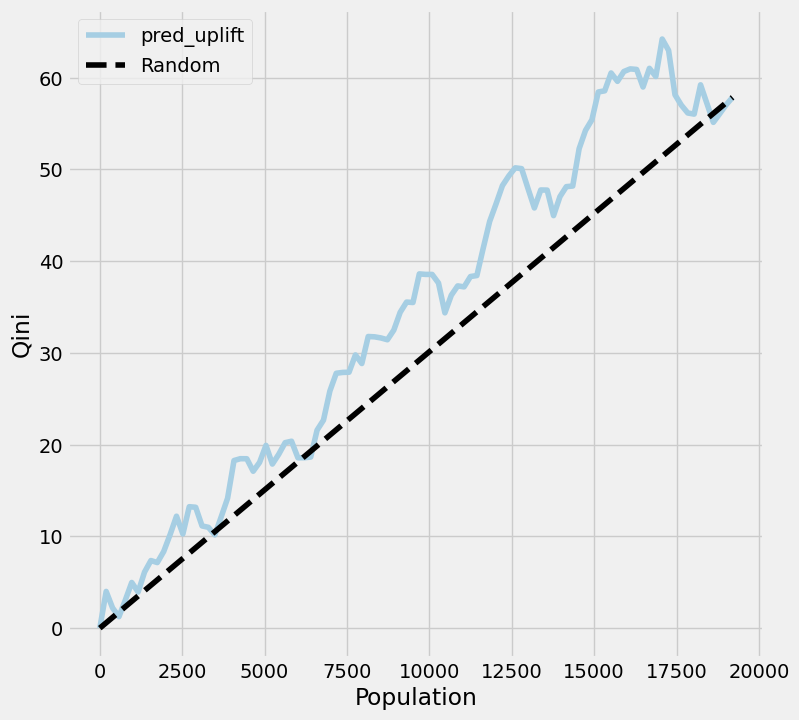

T-learnerのtau統計量:
 count    19200.000000
mean         0.004994
std          0.008398
min         -0.265786
25%          0.002875
50%          0.004977
75%          0.007089
max          0.200131
Name: tau, dtype: float64
Qiniスコア(T-learner)の計算中にエラー: No objects to concatenate
   y  w  pred_uplift
0  0  1     0.001616
1  0  1     0.001352
2  0  1     0.006094
3  0  1     0.008812
4  0  1     0.007962
Qiniスコア: pred_uplift    0.100202
dtype: float64


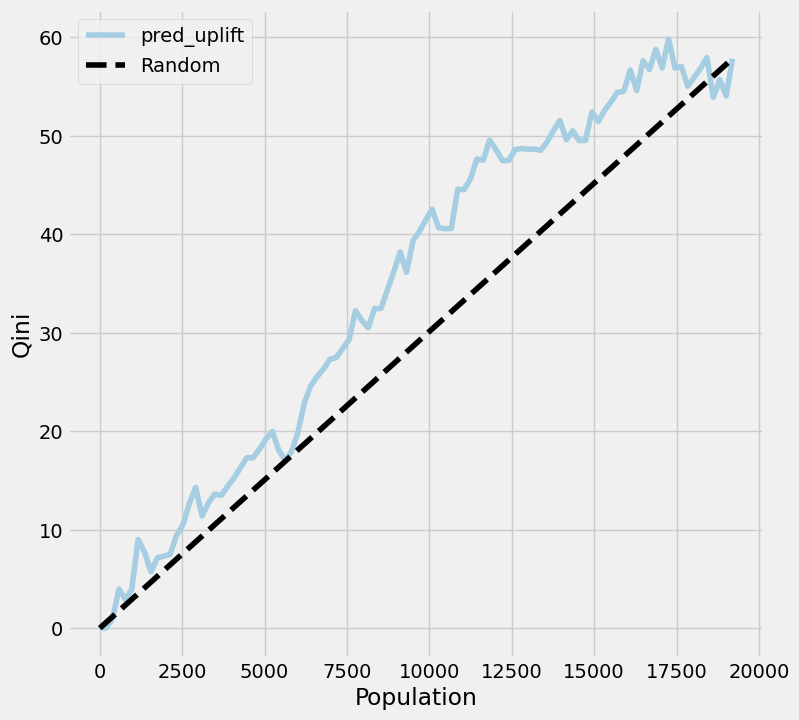

X-learnerのtau統計量:
 count    19200.000000
mean         0.004899
std          0.006597
min         -0.245554
25%          0.003750
50%          0.004688
75%          0.005599
max          0.086225
Name: tau, dtype: float64
Qiniスコア(X-learner)の計算中にエラー: No objects to concatenate
   y  w  pred_uplift
0  0  1     0.003629
1  0  1     0.003325
2  0  1     0.004375
3  0  1     0.005770
4  0  1     0.005930
Qiniスコア: pred_uplift    0.107034
dtype: float64


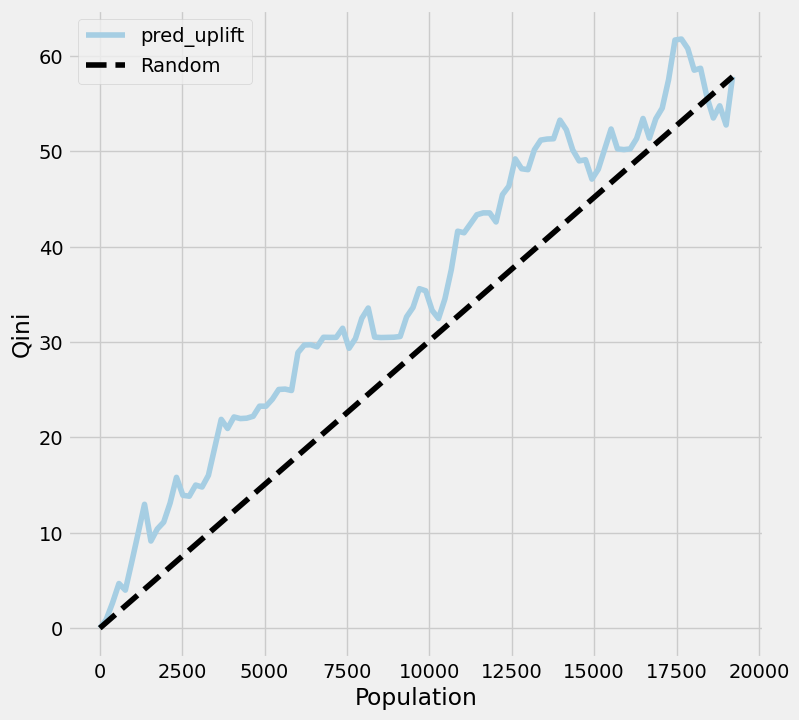

R-learnerのtau統計量:
 count    19200.000000
mean         0.005376
std          0.009748
min         -0.253608
25%          0.003681
50%          0.004632
75%          0.005459
max          0.570405
Name: tau, dtype: float64
Qiniスコア(R-learner)の計算中にエラー: No objects to concatenate
   y  w  pred_uplift
0  0  1     0.003682
1  0  1     0.003725
2  0  1     0.005896
3  0  1     0.005298
4  0  1     0.005497
Qiniスコア: pred_uplift    0.087709
dtype: float64


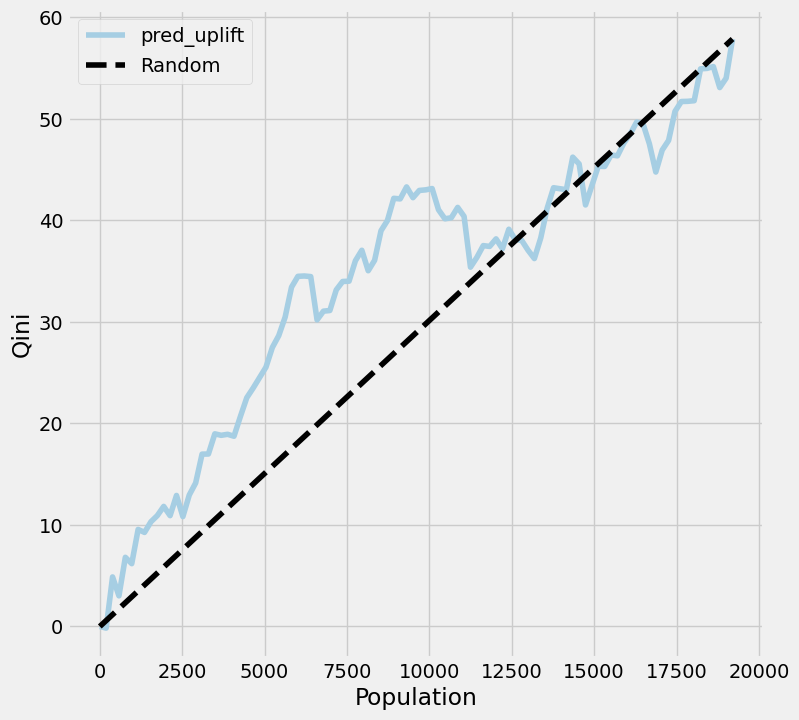

CausalTree: cate_pred の長さ 38400 が y_test の長さ 19200 と一致しないため、先頭からスライスします。
CausalTreeのtau統計量:
 count    19200.000000
mean         0.008091
std          0.005323
min          0.000000
25%          0.004637
50%          0.008734
75%          0.010446
max          0.038835
Name: tau, dtype: float64
Qiniスコア(CausalTree)の計算中にエラー: No objects to concatenate
   y  w  pred_uplift
0  0  1     0.012422
1  0  1     0.000000
2  0  1     0.006243
3  0  1     0.010446
4  0  1     0.010443
Qiniスコア: pred_uplift    0.195155
dtype: float64


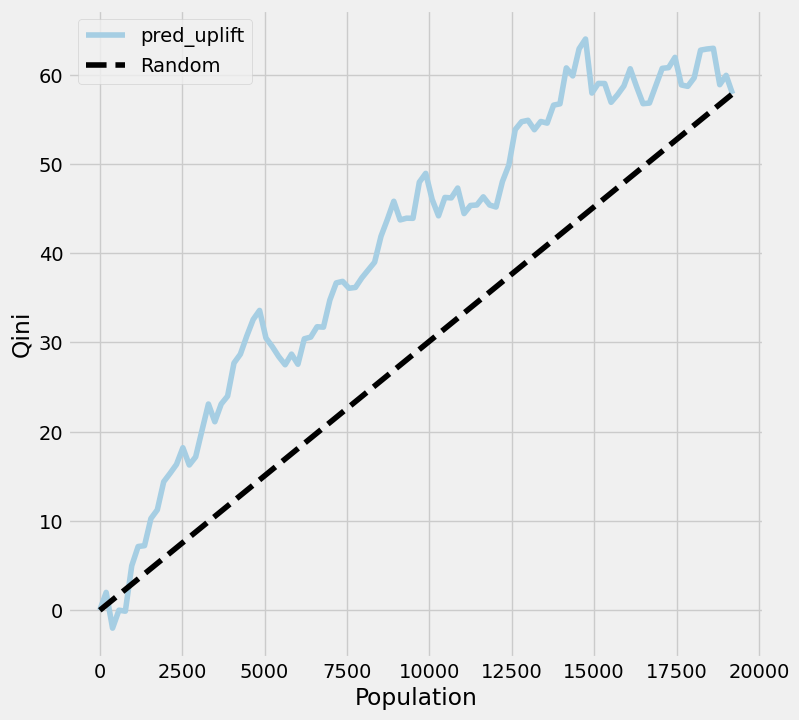

UpliftRFのtau統計量:
 count    19200.000000
mean         0.005287
std          0.003129
min         -0.006371
25%          0.003315
50%          0.005107
75%          0.007272
max          0.024110
Name: tau, dtype: float64
Qiniスコア(UpliftRF)の計算中にエラー: No objects to concatenate
   y  w  pred_uplift
0  0  1     0.002755
1  0  1     0.003505
2  0  1     0.007272
3  0  1     0.002837
4  0  1     0.005876
Qiniスコア: pred_uplift    0.198231
dtype: float64


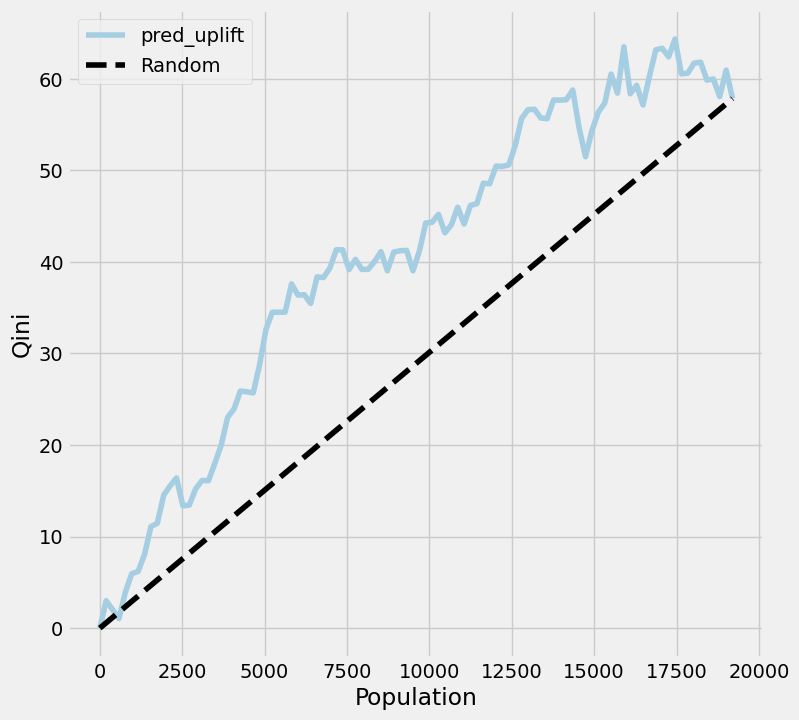

In [34]:
from causalml.metrics import qini_score
import numpy as np
import pandas as pd

# 各モデルの予測結果は models に入っていると仮定
# w_test, y_test は既に定義されているものとします

for name, cate_pred in models.items():
    # cate_predが2次元の場合、1次元に変換する
    if cate_pred.ndim > 1:
        cate_pred = cate_pred.flatten()
    
    # もし予測値の長さが y_test と異なる場合は、先頭からスライスして合わせる
    if len(cate_pred) != len(y_test):
        print(f"{name}: cate_pred の長さ {len(cate_pred)} が y_test の長さ {len(y_test)} と一致しないため、先頭からスライスします。")
        cate_pred = cate_pred[:len(y_test)]
    
    # DataFrame作成
    df_eval = pd.DataFrame({
        'y': y_test,
        'w': w_test,
        'tau': cate_pred
    })
    
    # tauの分布確認（オプション）
    print(f"{name}のtau統計量:\n", df_eval['tau'].describe())
    
    # 微小なノイズを加えて、tauの重複値を微妙に分散させる
    df_eval['tau'] = df_eval['tau'] + np.random.normal(0, 1e-6, size=len(df_eval))
    
    # qini_scoreの計算（treatment_effect_col を明示的に指定）
    try:
        score = qini_score(
            df_eval,
            outcome_col='y',
            treatment_col='w',
            treatment_effect_col='tau',
            normalize=True
        )
        print(f"Qiniスコア({name}): {score:.4f}")
    except ValueError as e:
        print(f"Qiniスコア({name})の計算中にエラー: {e}")


    from causalml.metrics import plot_qini
    #y_test, w_test, cate_pred がすべて長さNの1次元配列/Seriesであることを確認
    assert len(y_test) == len(w_test) == len(cate_pred), "配列長が一致していません"
    # DataFrameを作成（インデックスをリセットして揃える）
    df_qini = pd.DataFrame({
        'y': np.array(y_test).ravel(),      # 目的変数（実績値）
        'w': np.array(w_test).ravel(),      # 介入フラグ（0/1）
        'pred_uplift': np.array(cate_pred).ravel()  # モデル予測Uplift効果
    })
    # 列名 'y', 'w' はデフォルトと一致させる（or 引数で指定する）
    print(df_qini.head())  # 確認: DataFrameの先頭を表示
    from causalml.metrics import qini_score
    
    score = qini_score(df_qini, outcome_col='y', treatment_col='w')
    print(f"Qiniスコア: {score}")

    from causalml.metrics import plot_qini
    import matplotlib.pyplot as plt
    
    # 先ほど作成したdf_qiniを利用
    plot_qini(df_qini, outcome_col='y', treatment_col='w')
    plt.show()  # （Jupyter環境では不要ですが、スクリプト実行時は明示的に表示）


In [36]:
df_qini.to_dict()

{'y': {0: 0,
  1: 0,
  2: 0,
  3: 0,
  4: 0,
  5: 0,
  6: 0,
  7: 0,
  8: 0,
  9: 0,
  10: 0,
  11: 0,
  12: 0,
  13: 0,
  14: 0,
  15: 0,
  16: 0,
  17: 0,
  18: 0,
  19: 0,
  20: 0,
  21: 0,
  22: 0,
  23: 0,
  24: 0,
  25: 0,
  26: 0,
  27: 0,
  28: 0,
  29: 0,
  30: 0,
  31: 0,
  32: 0,
  33: 0,
  34: 0,
  35: 0,
  36: 0,
  37: 0,
  38: 0,
  39: 0,
  40: 0,
  41: 0,
  42: 0,
  43: 0,
  44: 0,
  45: 0,
  46: 0,
  47: 0,
  48: 0,
  49: 0,
  50: 0,
  51: 0,
  52: 0,
  53: 0,
  54: 0,
  55: 0,
  56: 0,
  57: 1,
  58: 0,
  59: 0,
  60: 0,
  61: 0,
  62: 0,
  63: 0,
  64: 0,
  65: 0,
  66: 0,
  67: 0,
  68: 0,
  69: 0,
  70: 0,
  71: 0,
  72: 0,
  73: 0,
  74: 0,
  75: 0,
  76: 0,
  77: 0,
  78: 0,
  79: 0,
  80: 0,
  81: 0,
  82: 0,
  83: 0,
  84: 0,
  85: 0,
  86: 0,
  87: 0,
  88: 0,
  89: 0,
  90: 0,
  91: 0,
  92: 0,
  93: 0,
  94: 0,
  95: 0,
  96: 0,
  97: 0,
  98: 0,
  99: 0,
  100: 0,
  101: 0,
  102: 0,
  103: 0,
  104: 0,
  105: 0,
  106: 0,
  107: 0,
  108: 0,
  109: 0,
  110

In [ ]:
# api構築について
#https://chatgpt.com/c/67bbf426-f938-8000-af33-8ce7dc6fa019